In [ ]:
#Importing all the neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

%matplotlib inline

import re
import string
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def extract_zip(zip_file):
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall()
        print("Zip file extracted successfully.")
    except zipfile.BadZipFile:
        print("Error: Not a valid zip file.")
    except FileNotFoundError:
        print("Error: File not found.")

zip_file = "6_class_data_v2.zip"
extract_zip(zip_file)

Zip file extracted successfully.


In [ ]:
# Define the root directory
root_dir = '/content/6_class_data_v2'

# Initialize lists to store category and poem data
categories = []
poems = []

# Iterate through each folder in the root directory
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)

    # Check if the item in the root directory is a folder
    if os.path.isdir(folder_path):
        # Extract category from folder name
        category = folder.split('__')[0]

        # Iterate through each text file in the folder
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)

            # Read the content of the text file
            with open(file_path, 'r', encoding='utf-8') as f:
                poem_content = f.readlines()
                poem = ' '.join(poem_content).replace('\n', '')

            # Append category and poem content to lists
            categories.append(category)
            poems.append(poem)

# Create DataFrame from the lists
df = pd.DataFrame({'Category': categories, 'Poem': poems})

# Display the DataFrame
df.head()

,Category,Poem
0,Religion_659,We plot our own destiny Be it the path to happ...
1,Religion_659,I want to go to heaven one of these days Toget...
2,Religion_659,
3,Religion_659,thuhte me thaet ic gesawe syllicre treow beama...
4,Religion_659,If your Fate is Sealed... Where will it be to ...


In [ ]:
# Handling long poems
# Function to split long poems
def split_long_poems(poem, max_words=150):
    words = poem.split()
    return [' '.join(words[i:i + max_words]) for i in range(0, len(words), max_words)]

df['Category'] = df['Category'].replace("Religion_659", "Religion")

# Create a new dataframe to store the split poems
new_rows = []

for _, row in df.iterrows():
    poem = row['Poem']
    category = row['Category']
    words = poem.split()

    if len(words) > 150:
        split_poems = split_long_poems(poem, max_words=150)
        for sp in split_poems:
            new_rows.append({'Poem': sp, 'Category': category})
    else:
        new_rows.append({'Poem': poem, 'Category': category})

# Create a new dataframe from the new rows
new_df = pd.DataFrame(new_rows)

# Drop rows where poem length is less than 10 words
new_df['WordCount'] = new_df['Poem'].apply(lambda x: len(x.split()))
final_df = new_df[new_df['WordCount'] >= 10]

# Drop the WordCount column as it is no longer needed
final_df = final_df.drop(columns=['WordCount'])

print(final_df)

                                                    Poem  Category
0      We plot our own destiny Be it the path to happ...  Religion
1      I want to go to heaven one of these days Toget...  Religion
3      thuhte me thaet ic gesawe syllicre treow beama...  Religion
4      heanne Bifode ic tha me se beorn ymbclypte Ne ...  Religion
5      fram tham maeran theodne Reste he daer maete w...  Religion
...                                                  ...       ...
15272  Love is pain So scars remain Mind and body, It...      Love
15273  The river else doesn’t wholly reign, But pale-...      Love
15274  Oh it's so easy to say - 'Give what you think ...      Love
15275  Well, honey it is January And soon it will be ...      Love
15276  so when i walk down the street i hold hands wi...      Love

[14807 rows x 2 columns]


In [ ]:
df = final_df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14807 entries, 0 to 15276
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Poem      14807 non-null  object
 1   Category  14807 non-null  object
dtypes: object(2)
memory usage: 347.0+ KB


<a id="de"></a>
# <p style="background-color:#F4B41A;font-family:newtimeroman;color:#143D59;font-size:150%;text-align:center;border-radius:50px 60px;">Data Exploration</p>

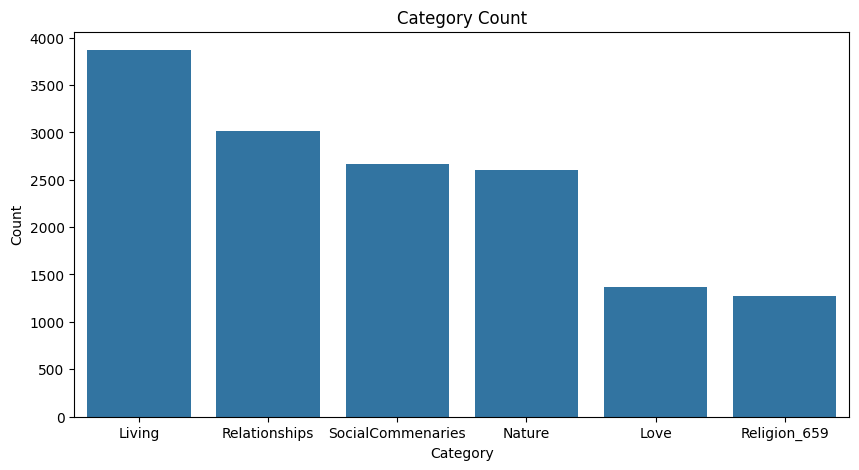

In [ ]:
#Generating a countplot for target label
plt.figure(figsize=(10,5))
sns.barplot(x=df['Category'].value_counts().index,y=df['Category'].value_counts())
plt.title('Category Count')
plt.xlabel('Category')
plt.ylabel('Count');

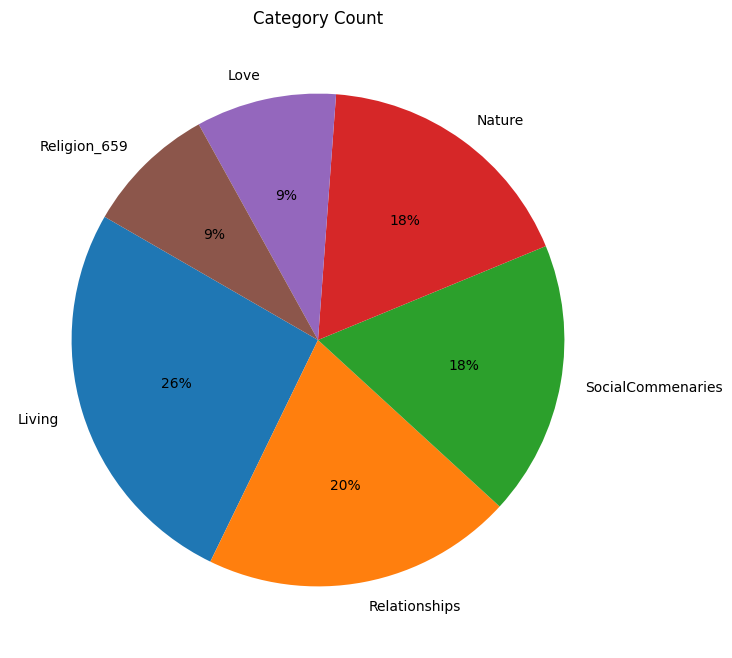

In [ ]:
#Generating a pie chart for target label
plt.figure(figsize=(10,8))
plt.pie(x=df['Category'].value_counts(),labels=df['Category'].value_counts().index,textprops={'fontsize':10},startangle=150,autopct='%1.0f%%')
plt.title('Category Count');

In [ ]:
#Count for each genre
df['Category'].value_counts()

Category
Living               3870
Relationships        3019
SocialCommenaries    2670
Nature               2607
Love                 1364
Religion_659         1277
Name: count, dtype: int64

<a id="wordcloud"></a>
# <p style="background-color:#F4B41A;font-family:newtimeroman;color:#143D59;font-size:150%;text-align:center;border-radius:50px 60px;">Wordcloud</p>


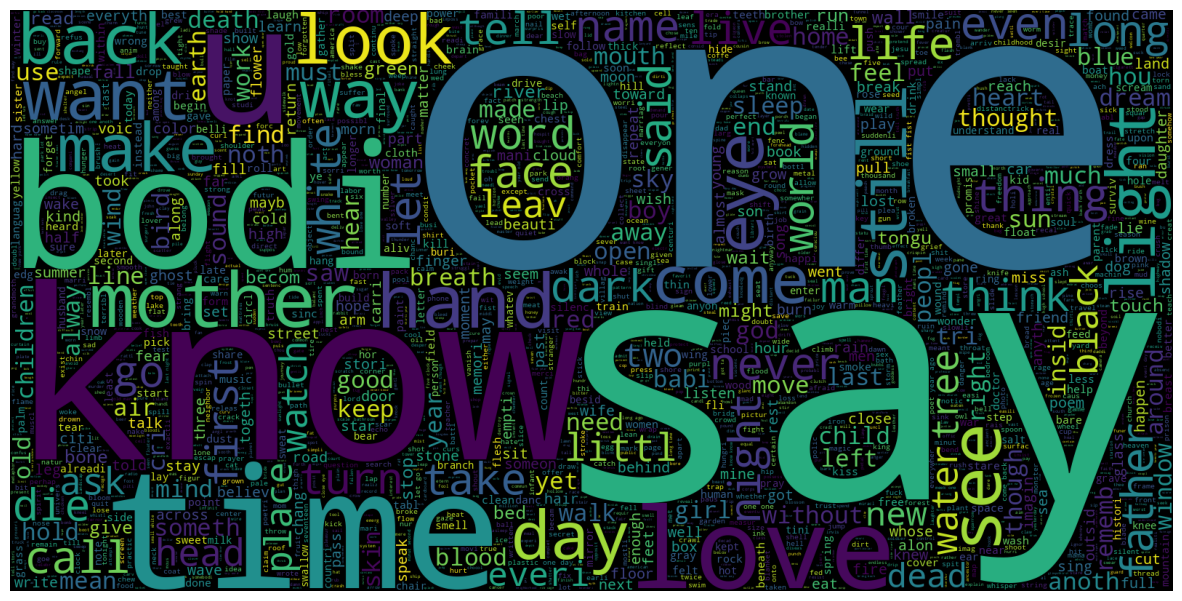

In [ ]:
text=' '.join(df[df['Category']=='Living']['Poem'])
plt.figure(figsize=(15,10))
wordcloud=WordCloud(max_words=5000,height=800,width=1600,background_color='black',colormap='viridis').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

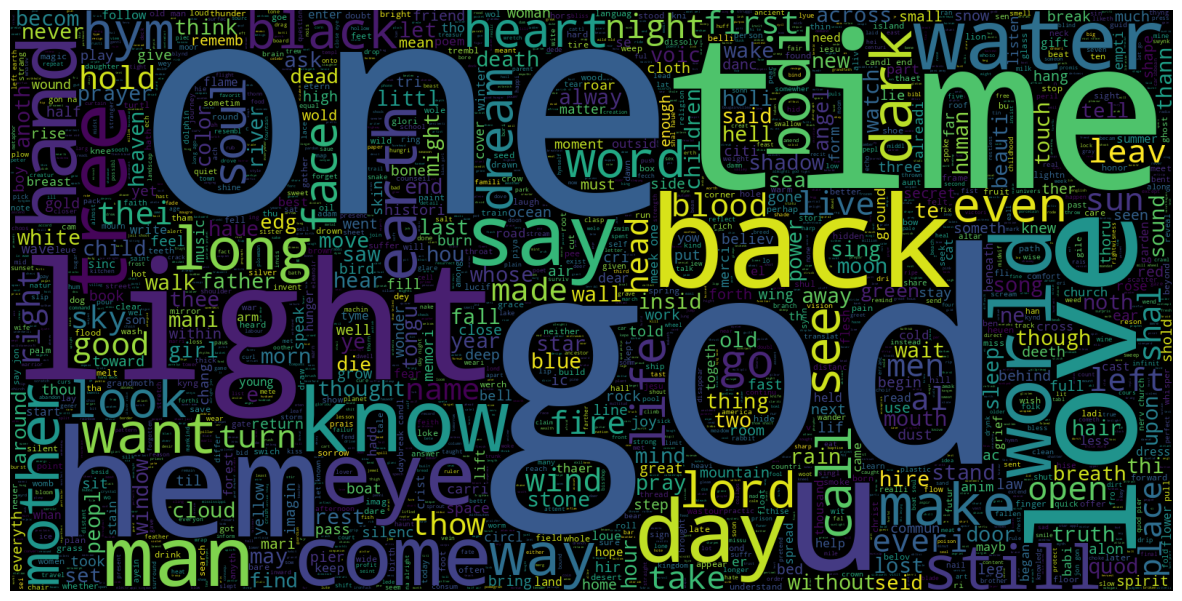

In [ ]:
text=' '.join(df[df['Category']=='Religion']['Poem'])
plt.figure(figsize=(15,10))
wordcloud=WordCloud(max_words=5000,height=800,width=1600,background_color='black',colormap='viridis').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<a id="le"></a>
# <p style="background-color:#F4B41A;font-family:newtimeroman;color:#143D59;font-size:150%;text-align:center;border-radius:50px 60px;">Label Encoding the target column i.e. 'genre'</p>

In [ ]:
from sklearn.utils import resample

# Perform undersampling to balance the categories
min_count = df['Category'].value_counts().min()

balanced_df = df.groupby('Category').apply(lambda x: resample(x, n_samples=min_count)).reset_index(drop=True)
balanced_df['Poem'] = balanced_df['Poem'].apply(str.lower)
balanced_df['Category'].value_counts()

Category
Living               1277
Love                 1277
Nature               1277
Relationships        1277
Religion             1277
SocialCommenaries    1277
Name: count, dtype: int64

In [ ]:
df = balanced_df

In [ ]:
df.head()

,Poem,Category
0,grief to burn away that which binds us enrichi...,Living
1,she d start the fires under the bed i d put th...,Living
2,there’s a mirror likeness between those two sh...,Living
3,interval. somewhere. very near. just around th...,Living
4,after being abducted by aliens and left incohe...,Living


In [ ]:
import torch
! pip install -U accelerate
! pip install -U transformers
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
! pip install datasets
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])
num_categories = len(label_encoder.classes_)

# Tokenize data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_function(examples):
    return tokenizer(examples['Poem'], padding="max_length", truncation=True, max_length=150)

# Create Dataset objects
dataset = Dataset.from_pandas(df)
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("Category", "labels")
tokenized_datasets.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Split into train and test sets
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/7662 [00:00<?, ? examples/s]

In [ ]:
# Load pre-trained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=30,  # Increase epochs for small dataset
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

data_collator = DataCollatorWithPadding(tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).mean()}
)

trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

| Metric                    | Value                |
|---------------------------|----------------------|
| eval_loss                 | 1.4073437452316284   |
| eval_accuracy             | 0.7699115044247787   |
| eval_runtime              | 3.8497               |
| eval_samples_per_second   | 117.413              |
| eval_steps_per_second     | 14.806               |
| epoch                     | 20.0                 |

# Save & Test

In [ ]:
# Save the model and tokenizer
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def predict_poem_category(poem):

    from transformers import BertTokenizer, BertForSequenceClassification
    import torch
    import numpy
    from sklearn.preprocessing import LabelEncoder

    label_encoder = LabelEncoder()
    label_encoder.classes_ = numpy.load('/content/drive/MyDrive/Poetry/classes.npy', allow_pickle=True)

    # Load the model and tokenizer
    model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Poetry/saved_model")
    tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/Poetry/saved_model")

    # Tokenize the input poems
    poems = [poem]
    inputs = tokenizer(poems, padding=True, truncation=True, return_tensors="pt", max_length=128)

    # Get predictions
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)

    # Decode the predicted labels
    predicted_labels = label_encoder.inverse_transform(predictions.cpu().numpy())
    return predicted_labels

In [ ]:
# Example usage
lovers_poem = "In a quiet town where the rivers flow, Two hearts intertwined, a love to grow. She, with eyes like stars that light the night, He, with a smile that makes the world bright. Beneath the willow where the shadows play, They found their haven, far from the fray. Her laughter, a melody, soft and sweet, His voice, a promise, their souls to meet. In secret whispers, they shared their dreams, Of future days and moonlit streams. Hands clasped tight, they faced the storms, Two lovers bound in their own warm norms. Through autumn's gold and winter's frost, They held on tight, whatever the cost. Spring's blossoms brought hope anew, And summer's sun bathed their love in hue."

predicted_categories = predict_poem_category(lovers_poem)

print(predicted_categories)

['Love']
